In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'emotional_intensity'
values = df[TARGET_COLUMN].unique().tolist()
values

['normal', 'strong']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1]), array([1310, 1119]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1450, 231)
Val: (363, 231)
Test: (616, 231)


### Default plots

In [7]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            plot_function="predict", levels=None, linewidths=1.5,
                            embedding=None, n_pts=30,
                            ax=None, subsamp_fraction=0.5,
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    
    edges_color = (0.2, 0.2, 0.2)
    edges_color_neg = (0.8, 0.8, 0.8)
    
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
        
    if levels is None:
        levels=len(np.unique(y))-1
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    plotting_function = getattr(predictor, plot_function)
    results = plotting_function(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=levels)
    
    
    # Plots the scatter
    subsamp = np.random.uniform(0,1, size=len(test_mask)) < subsamp_fraction
    plt.scatter(*embedding[(~test_mask)&(subsamp)].T, c=y[(~test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=None,  
                s=7, 
                cmap=cmap,
                alpha=1,
                label="train+val")
    plt.scatter(*embedding[test_mask&subsamp].T, c=y[(test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=edges_color, 
                s=7,
                cmap=cmap,
                alpha=1,
                label="test")
    
    # Plot contours without color
    plt.contour(XX, YY, results.T, alpha=1, 
                levels=levels, 
                colors=[edges_color, edges_color_neg],
                   linewidths=linewidths)

    plt.legend()
    plt.axis("off");
    plt.title(title);
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix", cmap="Greens"):
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap=cmap, fmt=".4g", cbar=False, ax=ax, vmin=0)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_aspect("equal")
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

### Select and embedding

In [9]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(X)

In [10]:
# Some properties
N_PTS = 80
CMAP = "Spectral"
CMAP_CFM = "RdGy_r"

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-08 23:42:30,851] A new study created in memory with name: no-name-59500393-d1e3-4f50-bf9c-beed2e58e77a
[W 2023-07-08 23:42:30,871] Trial 3 failed with parameters: {'penalty': 'none', 'C': 2.491872718347684, 'solver': 'liblinear'} because of the following error: ValueError("penalty='none' is not supported for the liblinear solver").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, i

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-07-08 23:42:34,013] Trial 6 finished with value: 0.7520661157024794 and parameters: {'penalty': 'l2', 'C': 0.6951476643233809, 'solver': 'saga'}. Best is trial 1 with value: 0.7520661157024794.
[W 2023-07-08 23:42:34,110] Trial 15 failed with parameters: {'penalty': 'l1', 'C': 6.6822792560

[W 2023-07-08 23:42:34,243] Trial 20 failed with value None.
[W 2023-07-08 23:42:34,256] Trial 21 failed with parameters: {'penalty': 'none', 'C': 4.642757110989381, 'solver': 'liblinear'} because of the following error: ValueError("penalty='none' is not supported for the liblinear solver").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='none'

[W 2023-07-08 23:42:37,748] Trial 31 failed with value None.
[W 2023-07-08 23:42:37,808] Trial 32 failed with parameters: {'penalty': 'elasticnet', 'C': 3.517545804933403, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-07-08 23:42:37,944] Trial 35 failed with parameters: {'penalty': 'elasticnet', 'C': 4.060358410109733, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtua

[W 2023-07-08 23:42:38,216] Trial 41 failed with parameters: {'penalty': 'elasticnet', 'C': 3.4276934502546252, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none

[W 2023-07-08 23:42:38,603] Trial 49 failed with value None.
[W 2023-07-08 23:42:38,602] Trial 50 failed with parameters: {'penalty': 'elasticnet', 'C': 3.59180043068425, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueErr

[W 2023-07-08 23:42:38,864] Trial 57 failed with parameters: {'penalty': 'elasticnet', 'C': 3.257757444488169, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Only 'saga' solver supports elasticnet penal

[W 2023-07-08 23:42:39,243] Trial 64 failed with value None.
[W 2023-07-08 23:42:39,244] Trial 65 failed with value None.
[W 2023-07-08 23:42:39,312] Trial 67 failed with parameters: {'penalty': 'elasticnet', 'C': 3.364453871942522, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_

[W 2023-07-08 23:42:39,576] Trial 74 failed with parameters: {'penalty': 'elasticnet', 'C': 3.311099207175357, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none'

[W 2023-07-08 23:42:39,920] Trial 81 failed with value None.
[W 2023-07-08 23:42:39,919] Trial 82 failed with parameters: {'penalty': 'elasticnet', 'C': 3.457680709012967, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueEr

[W 2023-07-08 23:42:40,246] Trial 89 failed with value None.
[W 2023-07-08 23:42:40,276] Trial 90 failed with parameters: {'penalty': 'elasticnet', 'C': 3.413183295339881, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Valu

[W 2023-07-08 23:42:40,632] Trial 97 failed with value None.
[W 2023-07-08 23:42:40,645] Trial 98 failed with parameters: {'penalty': 'elasticnet', 'C': 3.4364236606967067, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Val

[W 2023-07-08 23:42:40,917] Trial 104 failed with value None.
[W 2023-07-08 23:42:40,928] Trial 105 failed with value None.
[W 2023-07-08 23:42:40,978] Trial 106 failed with parameters: {'penalty': 'elasticnet', 'C': 3.623749879360132, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_

[W 2023-07-08 23:42:41,264] Trial 113 failed with parameters: {'penalty': 'elasticnet', 'C': 3.5896118536128343, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'non

[W 2023-07-08 23:42:41,557] Trial 121 failed with value None.
[W 2023-07-08 23:42:41,640] Trial 122 failed with parameters: {'penalty': 'elasticnet', 'C': 3.4357187859405687, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise Valu

[W 2023-07-08 23:42:42,077] Trial 130 failed with value None.
[W 2023-07-08 23:42:42,067] Trial 129 failed with parameters: {'penalty': 'elasticnet', 'C': 3.344026679199544, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise Value

[W 2023-07-08 23:42:42,448] Trial 137 failed with value None.
[W 2023-07-08 23:42:42,507] Trial 138 failed with parameters: {'penalty': 'elasticnet', 'C': 3.4098450961160323, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise Valu

[W 2023-07-08 23:42:43,055] Trial 145 failed with value None.
[W 2023-07-08 23:42:43,096] Trial 146 failed with parameters: {'penalty': 'elasticnet', 'C': 3.05184757826157, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Val

In [13]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l1', 'C': 5.735219301175046, 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       332
           1       0.71      0.68      0.69       284

    accuracy                           0.72       616
   macro avg       0.72      0.72      0.72       616
weighted avg       0.72      0.72      0.72       616

Accuracy 0.7224025974025974
F1-score [0.74741507 0.69189189]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

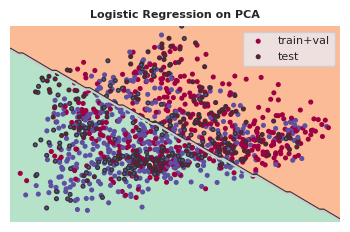

In [14]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title="Logistic Regression on PCA", 
                        cmap="Spectral",
                        n_pts=N_PTS)

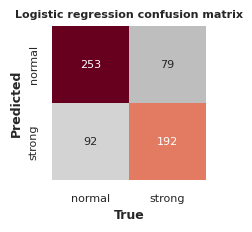

In [15]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix", cmap=CMAP_CFM)

# Support Vector Machine

## Linear SVM

In [16]:
from sklearn.svm import LinearSVC

In [17]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 23:42:50,061] A new study created in memory with name: no-name-1740102d-56c6-461b-8913-b387850bb17d
[W 2023-07-08 23:42:50,079] Trial 1 failed with parameters: {'penalty': 'l1', 'C': 66.91707316086375, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pyt

[W 2023-07-08 23:42:50,157] Trial 6 failed with value None.
[W 2023-07-08 23:42:50,153] Trial 4 failed with value None.
[W 2023-07-08 23:42:50,187] Trial 9 failed with parameters: {'penalty': 'l1', 'C': 53.65697432337111, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo

[W 2023-07-08 23:42:53,296] Trial 16 failed with value None.
[I 2023-07-08 23:42:53,299] Trial 7 finished with value: 0.6859504132231405 and parameters: {'penalty': 'l2', 'C': 64.65651276743291, 'loss': 'hinge'}. Best is trial 8 with value: 0.7327823691460055.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 23:42:55,475] Trial 12 finished with value: 0.6776859504132231 and parameters: {'penalty': 'l2', 'C': 76.89592307408763, 'loss': 'squared_hinge'}. Best is trial 8 with value: 0.7327823691460055.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 23:42:55,748] Trial 17 finished with value: 0.6804407713498623 and parameters: {'penalty': 'l2',

[W 2023-07-08 23:42:58,751] Trial 27 failed with value None.
[W 2023-07-08 23:42:58,793] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 99.09409033557085, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 23:42:58,988] Trial 33 failed with value None.
[W 2023-07-08 23:42:59,040] Trial 34 failed with parameters: {'penalty': 'l1', 'C': 92.29851124165727, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 23:42:59,228] Trial 38 failed with value None.
[W 2023-07-08 23:42:59,232] Trial 39 failed with value None.
[W 2023-07-08 23:42:59,256] Trial 40 failed with parameters: {'penalty': 'l1', 'C': 99.63770233058756, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-08 23:42:59,398] Trial 45 failed with value None.
[W 2023-07-08 23:42:59,401] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 97.66277689123436, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 23:42:59,541] Trial 51 failed with value None.
[W 2023-07-08 23:42:59,539] Trial 50 failed with value None.
[W 2023-07-08 23:42:59,537] Trial 49 failed with value None.
[W 2023-07-08 23:42:59,604] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 89.76712485145987, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, 

[W 2023-07-08 23:42:59,697] Trial 56 failed with value None.
[W 2023-07-08 23:42:59,719] Trial 58 failed with parameters: {'penalty': 'l1', 'C': 90.99096025429104, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 23:42:59,884] Trial 62 failed with value None.
[W 2023-07-08 23:42:59,886] Trial 64 failed with parameters: {'penalty': 'l1', 'C': 92.53970293149976, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 23:43:00,075] Trial 71 failed with parameters: {'penalty': 'l1', 'C': 90.40277696301082, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-07-08 23:43:00,183] Trial 74 failed with value None.
[W 2023-07-08 23:43:00,192] Trial 75 failed with value None.
[W 2023-07-08 23:43:00,241] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 96.98127096920298, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-08 23:43:00,374] Trial 81 failed with value None.
[W 2023-07-08 23:43:00,403] Trial 83 failed with parameters: {'penalty': 'l1', 'C': 95.35813870979268, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 23:43:00,521] Trial 87 failed with value None.
[I 2023-07-08 23:43:00,508] Trial 24 finished with value: 0.7162534435261708 and parameters: {'penalty': 'l2', 'C': 13.528756124121733, 'loss': 'squared_hinge'}. Best is trial 18 with value: 0.7741046831955923.
[W 2023-07-08 23:43:00,492] Trial 86 failed with value None.
[W 2023-07-08 23:43:00,619] Trial 89 failed with parameters: {'penalty': 'l1', 'C': 96.12298041373836, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train

[W 2023-07-08 23:43:00,727] Trial 93 failed with value None.
[W 2023-07-08 23:43:00,728] Trial 92 failed with value None.
[W 2023-07-08 23:43:00,732] Trial 94 failed with value None.
[W 2023-07-08 23:43:00,804] Trial 96 failed with parameters: {'penalty': 'l1', 'C': 92.45684865105608, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, 

[W 2023-07-08 23:43:00,945] Trial 99 failed with value None.
[W 2023-07-08 23:43:00,946] Trial 101 failed with parameters: {'penalty': 'l1', 'C': 98.85288284333973, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 23:43:01,093] Trial 106 failed with value None.
[W 2023-07-08 23:43:01,096] Trial 107 failed with parameters: {'penalty': 'l1', 'C': 99.76493075920689, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-08 23:43:01,264] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 92.69600339025641, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 23:43:01,405] Trial 118 failed with value None.
[W 2023-07-08 23:43:01,425] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 81.06251122598118, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-08 23:43:01,558] Trial 123 failed with value None.
[W 2023-07-08 23:43:01,559] Trial 125 failed with parameters: {'penalty': 'l1', 'C': 98.7471783252766, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 23:43:01,718] Trial 130 failed with value None.
[W 2023-07-08 23:43:01,689] Trial 129 failed with value None.
[W 2023-07-08 23:43:01,721] Trial 131 failed with parameters: {'penalty': 'l1', 'C': 87.89449313707175, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/d

[W 2023-07-08 23:43:01,891] Trial 137 failed with parameters: {'penalty': 'l1', 'C': 82.92929363802183, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 23:43:02,016] Trial 142 failed with value None.
[W 2023-07-08 23:43:02,038] Trial 143 failed with parameters: {'penalty': 'l1', 'C': 96.7826264839048, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 23:43:02,185] Trial 147 failed with parameters: {'penalty': 'l1', 'C': 95.03834212229494, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

In [18]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 94.04398508759697, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       332
           1       0.69      0.62      0.65       284

    accuracy                           0.69       616
   macro avg       0.69      0.69      0.69       616
weighted avg       0.69      0.69      0.69       616

Accuracy 0.6931818181818182
F1-score [0.72727273 0.64935065]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


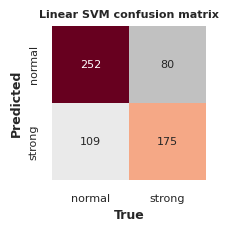

In [19]:
plot_cfm(y_test, y_pred_test, title="Linear SVM confusion matrix", cmap=CMAP_CFM)

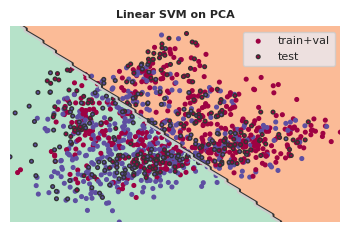

In [20]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title="Linear SVM on PCA", 
                        cmap=CMAP,
                       n_pts=N_PTS)

In [21]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [22]:
# # Plots the decision function for diferent values of C
# for i, C in enumerate([0.02, 300]):
#     plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

#     cmap="viridis"
#     clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

#     # Genearate a grid in embedding
#     xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
#     yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

#     XX, YY = np.meshgrid(xx, yy)
#     points_in_embedding = np.array(np.meshgrid(xx, yy)).T
#     old_shape = points_in_embedding.shape[:-1]
    
#     # Maps them back in the big space
#     points_in_embedding = points_in_embedding.reshape(-1,2)
#     points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

#     # Gets results
#     results = clf.decision_function(points_in_gigaspace)
#     mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
#     plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
#     plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
#     # Plot support
#     results = clf.decision_function(X_train)
#     support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
#     plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
#     plt.axis("off")
# #     decision_function = clf.decision_function(X_res_t)
# # #     we can also calculate the decision function manually
# # #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
# #     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# #     support_vectors = X_res_t[support_vector_indices]
# #     support_vectors_pca = pca.transform(support_vectors)

# #     plt.subplot(1, 2, i + 1)
# #     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
# #     ax = plt.gca()
# #     xlim = ax.get_xlim()
# #     ylim = ax.get_ylim()
# #     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
# #                          np.linspace(ylim[0], ylim[1], 50))
# #     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# #     Z = Z.reshape(xx.shape)
# #     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
# #                 linestyles=['--', '-', '--'])
# #     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
# #                 linewidth=1, facecolors='none', edgecolors='k')
# #     plt.title("C=" + str(C))
# #     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# # plt.tight_layout()
# # plt.show()
#     plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
#     plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [23]:
from sklearn.svm import SVC

In [24]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    degree = trial.suggest_int('degree', 1, 15)
    

    svc = SVC(kernel=kernel, gamma=gamma, C=C)

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 23:43:06,909] A new study created in memory with name: no-name-94d2dd22-5295-40ea-a175-7966e7f5d2f8
[I 2023-07-08 23:43:08,017] Trial 3 finished with value: 0.8099173553719008 and parameters: {'kernel': 'rbf', 'C': 28.497875793658864, 'gamma': 0.3922876871387659, 'degree': 11}. Best is trial 3 with value: 0.8099173553719008.
[I 2023-07-08 23:43:09,103] Trial 4 finished with value: 0.8126721763085399 and parameters: {'kernel': 'rbf', 'C': 76.40990960954908, 'gamma': 0.5343927363094386, 'degree': 2}. Best is trial 4 with value: 0.8126721763085399.
[I 2023-07-08 23:43:09,886] Trial 2 finished with value: 0.7355371900826446 and parameters: {'kernel': 'poly', 'C': 53.098450954368715, 'gamma': 0.6029492106619905, 'degree': 12}. Best is trial 4 with value: 0.8126721763085399.
[I 2023-07-08 23:43:10,168] Trial 1 finished with value: 0.7355371900826446 and parameters: {'kernel': 'poly', 'C': 78.90861451483867, 'gamma': 0.9144604775780862, 'degree': 15}. Best is trial 4 with value:

[I 2023-07-08 23:43:25,218] Trial 36 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 56.335334053268326, 'gamma': 0.8850363552648992, 'degree': 9}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:25,513] Trial 37 finished with value: 0.8154269972451791 and parameters: {'kernel': 'rbf', 'C': 50.77787682192876, 'gamma': 0.8098172334798585, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:25,870] Trial 38 finished with value: 0.8154269972451791 and parameters: {'kernel': 'rbf', 'C': 51.64571812376518, 'gamma': 0.8221842449037086, 'degree': 3}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:26,119] Trial 39 finished with value: 0.8154269972451791 and parameters: {'kernel': 'rbf', 'C': 52.843024157695076, 'gamma': 0.8133563500010711, 'degree': 13}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:26,850] Trial 40 finished with value: 0.8154269972451791 and paramet

[I 2023-07-08 23:43:43,180] Trial 73 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 24.70039577342272, 'gamma': 0.9639508326729362, 'degree': 8}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:43,260] Trial 72 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 49.01413275098048, 'gamma': 0.9597869002897256, 'degree': 8}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:43,336] Trial 74 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 47.937969644622285, 'gamma': 0.8873923757633779, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:44,528] Trial 75 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 58.37350757734258, 'gamma': 0.8782334427897114, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:43:45,078] Trial 76 finished with value: 0.8209366391184573 and paramete

[I 2023-07-08 23:44:00,143] Trial 107 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 68.67419127271555, 'gamma': 0.9422065049756043, 'degree': 3}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:00,461] Trial 110 finished with value: 0.8154269972451791 and parameters: {'kernel': 'rbf', 'C': 66.27919329511623, 'gamma': 0.7694687990022093, 'degree': 7}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:01,299] Trial 111 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 68.20458897004092, 'gamma': 0.9123994332710665, 'degree': 2}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:01,544] Trial 112 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 66.30961569310412, 'gamma': 0.9500981769043678, 'degree': 7}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:01,932] Trial 113 finished with value: 0.8154269972451791 and parame

[I 2023-07-08 23:44:16,300] Trial 145 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 53.592213881244135, 'gamma': 0.8611441440488505, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:16,383] Trial 146 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 61.035325421269846, 'gamma': 0.862297615792231, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:17,148] Trial 147 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 61.185790086231584, 'gamma': 0.857303571216302, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:18,244] Trial 148 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 64.63882000479592, 'gamma': 0.9357683608459259, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:18,389] Trial 149 finished with value: 0.8181818181818182 and p

[I 2023-07-08 23:44:35,790] Trial 181 finished with value: 0.5619834710743802 and parameters: {'kernel': 'sigmoid', 'C': 38.74209946444402, 'gamma': 0.8960457575397461, 'degree': 10}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:35,972] Trial 182 finished with value: 0.5619834710743802 and parameters: {'kernel': 'sigmoid', 'C': 60.641675637218725, 'gamma': 0.885671163222856, 'degree': 2}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:37,544] Trial 183 finished with value: 0.8181818181818182 and parameters: {'kernel': 'rbf', 'C': 60.450982429002906, 'gamma': 0.47635934460426965, 'degree': 4}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:37,787] Trial 185 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 60.490742214520104, 'gamma': 0.8724305298286559, 'degree': 9}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:37,805] Trial 184 finished with value: 0.820936639118457

[I 2023-07-08 23:44:52,768] Trial 216 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 23.674535650144666, 'gamma': 0.9250797662688254, 'degree': 2}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:52,941] Trial 218 finished with value: 0.8099173553719008 and parameters: {'kernel': 'rbf', 'C': 20.35425038321957, 'gamma': 0.5578079627256325, 'degree': 9}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:54,278] Trial 219 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 66.32549700996591, 'gamma': 0.9047687767403468, 'degree': 2}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:54,708] Trial 220 finished with value: 0.8209366391184573 and parameters: {'kernel': 'rbf', 'C': 58.23553315034979, 'gamma': 0.8829917756972897, 'degree': 2}. Best is trial 22 with value: 0.8209366391184573.
[I 2023-07-08 23:44:54,727] Trial 221 finished with value: 0.8209366391184573 and param

In [25]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 22.127547481718643, 'gamma': 0.8638650557090042, 'degree': 3}
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       332
           1       0.67      0.79      0.72       284

    accuracy                           0.72       616
   macro avg       0.73      0.73      0.72       616
weighted avg       0.73      0.72      0.72       616

Accuracy 0.7224025974025974
F1-score [0.72013093 0.72463768]


In [26]:
print(svc.support_vectors_.shape)
print(X.shape)

(1682, 231)
(2429, 231)


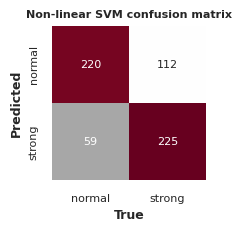

In [27]:
plot_cfm(y_test, y_pred_test, title="Non-linear SVM confusion matrix", cmap=CMAP_CFM)

In [28]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [29]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [30]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [31]:
# support_vectors_pca = pca.transform(support_vectors)

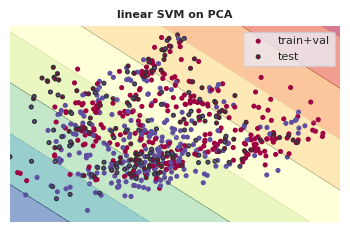

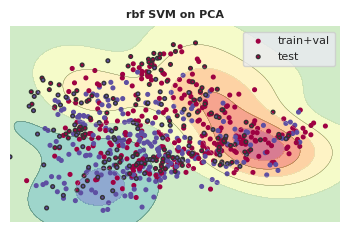

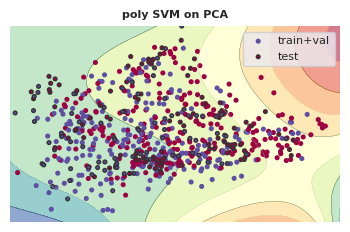

In [32]:
for kernel in ('linear', 'rbf', 'poly'):
    
    this_kernel_params = svc.get_params().copy()
    this_kernel_params["kernel"] = kernel
#     this_kernel_params["C"] = 0.5
    this_kernel_params["degree"] = 15
    
    clf = SVC(**this_kernel_params)
    clf.fit(X_train, y_train)
    
    boundaries_on_embedding(   reducer, clf, embedding=embedding,
                                title=f"{kernel} SVM on PCA",
                                plot_function="decision_function", levels=8, linewidths=0.2,
                                n_pts=100, subsamp_fraction=0.3,
                                cmap=CMAP
                           )
    

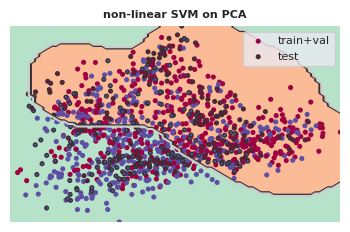

In [33]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title="non-linear SVM on PCA", 
                        cmap=CMAP,
                        n_pts=N_PTS)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [34]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

2023-07-08 23:45:34.596818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 23:45:34.658590: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 23:45:34.659429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 23:45:36.332961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
from scikeras.wrappers import KerasClassifier

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [39]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 23:45:38,088] A new study created in memory with name: no-name-db0d0cb3-42c3-45df-a05e-38969bd5aab0
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) 

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
45/46 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.5951Epoch 2/50
Epoch 2/50
46/46 [==============================] - 4s 11ms/step - loss: 0.6648 - accuracy: 0.5966
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5338
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6394 - accuracy: 0.6634
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6955 - accuracy: 0.5338
Epoch 4/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6913 - accuracy: 0.5338
Epoch 5/50
46/46 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 0.5338
Epoch 5/50
46/46 [==============================] - 6s 23ms/step - loss: 0.6413 - accuracy: 0.6359
Epoch 2/50
46/46 [==============================] - 1s 19ms/step - loss: 0.6918 - accuracy: 0.5338
Epoch 6/50
46/46 [==============================] - 1s 18ms/step - loss: 

46/46 [==============================] - 0s 10ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 17/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5378 - accuracy: 0.7234
Epoch 13/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6914 - accuracy: 0.5338
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5673 - accuracy: 0.7131
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5641 - accuracy: 0.7145
Epoch 19/50
21/46 [============>.................] - ETA: 0s - loss: 0.5566 - accuracy: 0.7113Epoch 20/50
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6912 - accuracy: 0.5338
Epoch 21/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6910 - accuracy: 0.5338
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5211 - accuracy: 0.7331
Epoch 17/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6910 - accuracy: 0.5338
Epoch 22/5

46/46 [==============================] - 0s 9ms/step - loss: 0.5534 - accuracy: 0.7159
Epoch 31/50
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 31/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5338
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5541 - accuracy: 0.7152
Epoch 32/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5208 - accuracy: 0.7276
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5482 - accuracy: 0.7207
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 35/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 36/

46/46 [==============================] - 0s 10ms/step - loss: 0.6911 - accuracy: 0.5338
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5395 - accuracy: 0.7269
Epoch 44/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.5338
Epoch 47/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.5338
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5397 - accuracy: 0.7214
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 49/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4501 - accuracy: 0.7779
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5397 - accuracy: 0.7234
Epoch 48/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5338
Epoch 50/50
Epoch

[I 2023-07-08 23:46:07,221] Trial 3 finished with value: 0.7520661157024794 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.7520661157024794.


28/46 [=================>............] - ETA: 0s - loss: 0.4401 - accuracy: 0.7913

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.4428 - accuracy: 0.7890
Epoch 50/50
12/12 [==============================] - 0s 7ms/step


[I 2023-07-08 23:46:08,186] Trial 0 finished with value: 0.7603305785123967 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
46/46 [==============================] - 2s 8ms/step - loss: 0.6765 - accuracy: 0.5855
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.6634
Epoch 3/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6807
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6938
Epoch 5/50
46/46 [==============================] - 2s 4ms/step - loss: 0.6912 - accuracy: 0.5034
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.6441
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.6993
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.6655
Epoch 4/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.6752
Epoch 8/50
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.6828
Epoch 9/5

46/46 [==============================] - 0s 4ms/step - loss: 0.5475 - accuracy: 0.7228
Epoch 39/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5601 - accuracy: 0.7193
Epoch 39/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5591 - accuracy: 0.7228
Epoch 40/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5450 - accuracy: 0.7221
Epoch 41/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5583 - accuracy: 0.7172
Epoch 41/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5427 - accuracy: 0.7248
Epoch 42/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5579 - accuracy: 0.7131
Epoch 42/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.7221
Epoch 43/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5569 - accuracy: 0.7179
Epoch 43/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5407 - accuracy: 0.7234
Epoch 44/50
46/46 [===

[I 2023-07-08 23:46:21,790] Trial 5 finished with value: 0.743801652892562 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 3ms/step - loss: 0.6923 - accuracy: 0.5152
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5338
Epoch 3/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5338
Epoch 4/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5338
Epoch 5/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5338
Epoch 6/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5338
Epoch 7/50
46/46 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5297
Epoch 8/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5338
Epoch 9/50
24/46 [==============>...............] - ETA: 0s - loss: 0.6896 - accuracy: 0.5469

[I 2023-07-08 23:46:24,004] Trial 1 finished with value: 0.5619834710743802 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

46/46 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5338
Epoch 10/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5338
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5338
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5310
Epoch 13/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5338
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5338
Epoch 15/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5303
Epoch 16/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5338
Epoch 17/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5338
Epoch 18/50
46/46 [==============================] - 3s 7ms/step - loss: 0.6868 - accuracy: 0.5510
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6694 - accuracy: 0.6048
Epoch 3/50
46/46 [=====

[I 2023-07-08 23:46:30,720] Trial 4 finished with value: 0.7548209366391184 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


27/46 [================>.............] - ETA: 0s - loss: 0.5539 - accuracy: 0.7280

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5816 - accuracy: 0.7069
Epoch 16/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5547 - accuracy: 0.7186
Epoch 11/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.5145
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5748 - accuracy: 0.7138
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.5338
Epoch 35/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5740 - accuracy: 0.7083
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5457 - accuracy: 0.7221
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6905 - accuracy: 0.5414
Epoch 16/50
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5710 - accuracy: 0.7145
Epoch 23/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5423 - accuracy: 0.7186
Epoch 17

46/46 [==============================] - 0s 8ms/step - loss: 0.6910 - accuracy: 0.5338
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5604 - accuracy: 0.7145
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5338
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5317 - accuracy: 0.7303
Epoch 10/50
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5586 - accuracy: 0.7193
Epoch 34/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5164 - accuracy: 0.7372
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6297 - accuracy: 0.6993
Epoch 29/50
Epoch 49/50
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5563 - accuracy: 0.7172
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6197 - accuracy: 0.6924
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5551 - acc

[I 2023-07-08 23:46:40,559] Trial 6 finished with value: 0.5619834710743802 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


 7/46 [===>..........................] - ETA: 0s - loss: 0.6309 - accuracy: 0.6518

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5539 - accuracy: 0.7207
Epoch 41/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5106 - accuracy: 0.7359
Epoch 35/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5534 - accuracy: 0.7221
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5053 - accuracy: 0.7483
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6024 - accuracy: 0.7076
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5150 - accuracy: 0.7386
Epoch 37/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5976 - accuracy: 0.7028
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5521 - accuracy: 0.7193
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5971 - accuracy: 0.7069
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5518 - accuracy: 0.7193
Epoch 45/50
46/46 [===

[I 2023-07-08 23:46:46,337] Trial 7 finished with value: 0.7134986225895317 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


Epoch 29/50
22/46 [=============>................] - ETA: 0s - loss: 0.4985 - accuracy: 0.7571

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.4913 - accuracy: 0.7531
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5756 - accuracy: 0.7090
Epoch 30/50
46/46 [==============================] - 6s 10ms/step - loss: 0.6649 - accuracy: 0.6179
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5936 - accuracy: 0.6945
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5012 - accuracy: 0.7538
Epoch 50/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5650 - accuracy: 0.7193
Epoch 34/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5586 - accuracy: 0.7241
Epoch 36/50
29/46 [=================>............] - ETA: 0s - loss: 0.5669 - accuracy: 0.7080

[I 2023-07-08 23:46:50,284] Trial 8 finished with value: 0.7575757575757576 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 7ms/step - loss: 0.5597 - accuracy: 0.7138
Epoch 37/50
16/46 [=========>....................] - ETA: 0s - loss: 0.5451 - accuracy: 0.7402

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5565 - accuracy: 0.7193
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5488 - accuracy: 0.7172
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5462 - accuracy: 0.7200
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5541 - accuracy: 0.7234
Epoch 41/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6728 - accuracy: 0.5855
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5522 - accuracy: 0.7124
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5487 - accuracy: 0.7234
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6524 - accuracy: 0.6469
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6465 - accuracy: 0.6441
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5461 - accuracy: 0.7214
Epoch 46/50
46/46 [==

[I 2023-07-08 23:46:59,485] Trial 9 finished with value: 0.7300275482093664 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 1s 17ms/step - loss: 0.6104 - accuracy: 0.6986
Epoch 8/50
25/46 [===============>..............] - ETA: 0s - loss: 0.6040 - accuracy: 0.6825

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.6015 - accuracy: 0.7021
Epoch 9/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5964 - accuracy: 0.7028
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5172 - accuracy: 0.7241
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5909 - accuracy: 0.7034
Epoch 22/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5884 - accuracy: 0.7090
Epoch 24/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4984 - accuracy: 0.7448
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5837 - accuracy: 0.7014
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5814 - accuracy: 0.7048
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4947 - accuracy: 0.7400
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5811 - accuracy: 0.7083
Epoch 28/50
46/46 

46/46 [==============================] - 0s 8ms/step - loss: 0.5551 - accuracy: 0.7179
Epoch 26/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4822 - accuracy: 0.7586
Epoch 40/50
36/46 [======================>.......] - ETA: 0s - loss: 0.5419 - accuracy: 0.7344Epoch 35/50
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5519 - accuracy: 0.7283
Epoch 27/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5714 - accuracy: 0.7152
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5581 - accuracy: 0.7138
Epoch 37/50
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5537 - accuracy: 0.7179
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4747 - accuracy: 0.7579
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5533 - accuracy: 0.7097
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5495 - accuracy: 0.7359
Epoch 3

[I 2023-07-08 23:47:13,081] Trial 10 finished with value: 0.7520661157024794 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.7603305785123967.


15/46 [========>.....................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7229

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.5213 - accuracy: 0.7331
Epoch 18/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5418 - accuracy: 0.7228
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5220 - accuracy: 0.7366
Epoch 19/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5414 - accuracy: 0.7241
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5607 - accuracy: 0.7090
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5412 - accuracy: 0.7179
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5067 - accuracy: 0.7503
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5023 - accuracy: 0.7379
Epoch 22/50


[I 2023-07-08 23:47:15,026] Trial 11 finished with value: 0.7245179063360881 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


18/46 [==========>...................] - ETA: 0s - loss: 0.5106 - accuracy: 0.7274Epoch 44/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.4992 - accuracy: 0.7490
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5360 - accuracy: 0.7193
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4960 - accuracy: 0.7469
Epoch 25/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5021 - accuracy: 0.7483
Epoch 27/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5364 - accuracy: 0.7283
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4830 - accuracy: 0.7607
Epoch 28/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5359 - accuracy: 0.7138
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4959 - accuracy: 0.7448
Epoch 29/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4823 - accuracy: 0.7600
Epoch 30/50
36/46 [======================>.......] - ETA: 0s - loss: 0.4648 - accuracy: 0.7769

[I 2023-07-08 23:47:19,431] Trial 12 finished with value: 0.7493112947658402 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7603305785123967.


46/46 [==============================] - 0s 8ms/step - loss: 0.4778 - accuracy: 0.7690
Epoch 31/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.4563 - accuracy: 0.7604

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.6367 - accuracy: 0.6710
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4703 - accuracy: 0.7552
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4789 - accuracy: 0.7628
Epoch 35/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5914 - accuracy: 0.6966
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5764 - accuracy: 0.7062
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4576 - accuracy: 0.7731
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5715 - accuracy: 0.7145
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6061 - accuracy: 0.6848
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4602 - accuracy: 0.7690
Epoch 38/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5700 - accuracy: 0.7138
Epoch 8/50
46/46 [========

46/46 [==============================] - 0s 8ms/step - loss: 0.5381 - accuracy: 0.7214
Epoch 21/50
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5757 - accuracy: 0.7055
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5737 - accuracy: 0.7083
Epoch 17/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.5646 - accuracy: 0.6992

[I 2023-07-08 23:47:29,308] Trial 13 finished with value: 0.7658402203856749 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 13 with value: 0.7658402203856749.


39/46 [========================>.....] - ETA: 0s - loss: 0.5457 - accuracy: 0.7276

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5293 - accuracy: 0.7324
Epoch 23/50
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5509 - accuracy: 0.7172
Epoch 24/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5581 - accuracy: 0.7193
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5417 - accuracy: 0.7310
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5561 - accuracy: 0.7248
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5491 - accuracy: 0.7228
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5099 - accuracy: 0.7421
Epoch 14/50
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5441 - accuracy: 0.7221
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5074 - accuracy: 0.7469
Epoch 23/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5429 - accuracy: 0.

46/46 [==============================] - 0s 9ms/step - loss: 0.5288 - accuracy: 0.7366
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4826 - accuracy: 0.7524
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5344 - accuracy: 0.7283
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5123 - accuracy: 0.7462
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5291 - accuracy: 0.7372
Epoch 44/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5510 - accuracy: 0.7207
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4696 - accuracy: 0.7662
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5115 - accuracy: 0.7414
Epoch 32/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5311 - accuracy: 0.7290
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5397 - accuracy: 0.7276
Epoch 10/50
46/46 [====

[I 2023-07-08 23:47:42,435] Trial 14 finished with value: 0.7272727272727273 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.7658402203856749.


28/46 [=================>............] - ETA: 0s - loss: 0.4587 - accuracy: 0.7600

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.5235 - accuracy: 0.7303
Epoch 17/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4631 - accuracy: 0.7738
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5293 - accuracy: 0.7290
Epoch 18/50
42/46 [==========================>...] - ETA: 0s - loss: 0.4952 - accuracy: 0.7478Epoch 19/50
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4963 - accuracy: 0.7469
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5199 - accuracy: 0.7345
Epoch 43/50
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5198 - accuracy: 0.7407
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5024 - accuracy: 0.7434
Epoch 44/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5138 - accuracy: 0.7455
Epoch 22/50
11/46 [======>.......................] - ETA: 0s - loss: 0.4943 - accuracy: 0.7557

[I 2023-07-08 23:47:45,655] Trial 15 finished with value: 0.7520661157024794 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 13 with value: 0.7658402203856749.


24/46 [==============>...............] - ETA: 0s - loss: 0.5259 - accuracy: 0.7370

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.5164 - accuracy: 0.7366
Epoch 46/50
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4911 - accuracy: 0.7483
Epoch 47/50
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4888 - accuracy: 0.7566
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5061 - accuracy: 0.7455
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4878 - accuracy: 0.7545
Epoch 49/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5165 - accuracy: 0.7276
Epoch 26/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5007 - accuracy: 0.7469
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5016 - accuracy: 0.7517
Epoch 28/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.4862 - accuracy: 0.7465

[I 2023-07-08 23:47:49,164] Trial 16 finished with value: 0.7465564738292011 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.7658402203856749.


28/46 [=================>............] - ETA: 0s - loss: 0.5092 - accuracy: 0.7366

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.5021 - accuracy: 0.7517
Epoch 30/50
46/46 [==============================] - 7s 11ms/step - loss: 0.6897 - accuracy: 0.5359
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4930 - accuracy: 0.7517
Epoch 32/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4863 - accuracy: 0.7552
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6383 - accuracy: 0.6628
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4793 - accuracy: 0.7517
Epoch 34/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6176 - accuracy: 0.6972
Epoch 6/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4724 - accuracy: 0.7662
Epoch 35/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5996 - accuracy: 0.6972
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4790 - accuracy: 0.7559
Epoch 36/50
46/46 [=

46/46 [==============================] - 0s 8ms/step - loss: 0.5460 - accuracy: 0.7200
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5689 - accuracy: 0.7062
Epoch 50/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5383 - accuracy: 0.7200
Epoch 22/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5593 - accuracy: 0.7152
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5442 - accuracy: 0.7193
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5509 - accuracy: 0.7138
Epoch 24/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.7241
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5444 - accuracy: 0.7138
Epoch 19/50
Epoch 13/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5394 - accuracy: 0.7193
Epoch 26/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5611 - accuracy: 0.6993
Epoch 20/5

46/46 [==============================] - 0s 6ms/step - loss: 0.5128 - accuracy: 0.7345
Epoch 37/50
Epoch 31/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5225 - accuracy: 0.7324
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5183 - accuracy: 0.7276
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5212 - accuracy: 0.7331
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5173 - accuracy: 0.7352
Epoch 40/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5123 - accuracy: 0.7441
Epoch 41/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5108 - accuracy: 0.7448
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5159 - accuracy: 0.7297
Epoch 42/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5164 - accuracy: 0.7290
Epoch 50/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5163 - accuracy: 0.7414
Epoch 43/5

[I 2023-07-08 23:48:09,389] Trial 18 finished with value: 0.7575757575757576 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.7658402203856749.


46/46 [==============================] - 0s 10ms/step - loss: 0.5042 - accuracy: 0.7524
Epoch 45/50
20/46 [============>.................] - ETA: 0s - loss: 0.5093 - accuracy: 0.7391

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.5139 - accuracy: 0.7345
Epoch 46/50
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5010 - accuracy: 0.7517
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5129 - accuracy: 0.7441
Epoch 41/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5005 - accuracy: 0.7428
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5105 - accuracy: 0.7372
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5056 - accuracy: 0.7345
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4941 - accuracy: 0.7572
Epoch 50/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5047 - accuracy: 0.7490
Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5038 - accuracy: 0.7372


[I 2023-07-08 23:48:13,114] Trial 19 finished with value: 0.768595041322314 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


Epoch 46/50
19/46 [===========>..................] - ETA: 0s - loss: 0.5143 - accuracy: 0.7286

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.5048 - accuracy: 0.7428
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5086 - accuracy: 0.7352
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5006 - accuracy: 0.7503
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4961 - accuracy: 0.7462
Epoch 50/50
46/46 [==============================] - 6s 7ms/step - loss: 0.6841 - accuracy: 0.5531
Epoch 2/50
 1/46 [..............................] - ETA: 0s - loss: 0.6548 - accuracy: 0.7812

[I 2023-07-08 23:48:15,861] Trial 20 finished with value: 0.7493112947658402 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


25/46 [===============>..............] - ETA: 0s - loss: 0.6538 - accuracy: 0.6463

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.6433 - accuracy: 0.6690
Epoch 3/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5930 - accuracy: 0.7014
Epoch 4/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5748 - accuracy: 0.7131
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5680 - accuracy: 0.7179
Epoch 6/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5650 - accuracy: 0.7083
Epoch 7/50
38/46 [=======================>......] - ETA: 0s - loss: 0.6725 - accuracy: 0.6053

[I 2023-07-08 23:48:19,873] Trial 17 finished with value: 0.7575757575757576 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


46/46 [==============================] - 6s 17ms/step - loss: 0.6704 - accuracy: 0.6055
Epoch 2/50
 1/46 [..............................] - ETA: 1s - loss: 0.6129 - accuracy: 0.8125

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.5572 - accuracy: 0.7145
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6193 - accuracy: 0.6697
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5506 - accuracy: 0.7214
Epoch 11/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5827 - accuracy: 0.6966
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5747 - accuracy: 0.7034
Epoch 5/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5502 - accuracy: 0.7228
Epoch 14/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5697 - accuracy: 0.7083
Epoch 7/50
46/46 [==============================] - 8s 14ms/step - loss: 0.7590 - accuracy: 0.4662
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5630 - accuracy: 0.7124
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.7075 - accuracy: 0.4662
Epoch 3/50
46/46 [=

46/46 [==============================] - 1s 12ms/step - loss: 0.5456 - accuracy: 0.7186
Epoch 20/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6027 - accuracy: 0.7124
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5649 - accuracy: 0.7200
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5928 - accuracy: 0.7172
Epoch 16/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5509 - accuracy: 0.7117
Epoch 22/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5848 - accuracy: 0.7131
Epoch 17/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5366 - accuracy: 0.7331
Epoch 30/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5804 - accuracy: 0.7138
Epoch 11/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5714 - accuracy: 0.7228
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5321 - accuracy: 0.7428
Epoch 33/50
4

46/46 [==============================] - 1s 13ms/step - loss: 0.5322 - accuracy: 0.7262
Epoch 42/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5260 - accuracy: 0.7303
Epoch 35/50
Epoch 43/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5555 - accuracy: 0.7269
Epoch 30/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5352 - accuracy: 0.7345
Epoch 44/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5419 - accuracy: 0.7228
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5552 - accuracy: 0.7276
Epoch 31/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5295 - accuracy: 0.7352
Epoch 26/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5540 - accuracy: 0.7241
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5197 - accuracy: 0.7462
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5190 - accuracy: 0.7407


[I 2023-07-08 23:48:47,955] Trial 21 finished with value: 0.7355371900826446 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


10/46 [=====>........................] - ETA: 0s - loss: 0.4641 - accuracy: 0.7812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.5497 - accuracy: 0.7290
Epoch 40/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5227 - accuracy: 0.7276
Epoch 33/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5474 - accuracy: 0.7269
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5256 - accuracy: 0.7352
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5460 - accuracy: 0.7317
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5475 - accuracy: 0.7262
Epoch 43/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5033 - accuracy: 0.7455
Epoch 48/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5239 - accuracy: 0.7317
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5450 - accuracy: 0.7248
Epoch 46/50
37/46 [=======================>......] - ETA: 0s - loss: 0.5483 - accuracy: 0.7340

[I 2023-07-08 23:48:53,355] Trial 22 finished with value: 0.7493112947658402 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


46/46 [==============================] - 1s 13ms/step - loss: 0.5430 - accuracy: 0.7379
Epoch 48/50
30/46 [==================>...........] - ETA: 0s - loss: 0.5068 - accuracy: 0.7396

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.5101 - accuracy: 0.7421
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5403 - accuracy: 0.7324
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5096 - accuracy: 0.7524
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5058 - accuracy: 0.7414
Epoch 44/50
36/46 [======================>.......] - ETA: 0s - loss: 0.5103 - accuracy: 0.7543

[I 2023-07-08 23:48:56,112] Trial 23 finished with value: 0.7355371900826446 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


46/46 [==============================] - 1s 14ms/step - loss: 0.5039 - accuracy: 0.7552
Epoch 45/50
 1/46 [..............................] - ETA: 1s - loss: 0.4686 - accuracy: 0.7812

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.5056 - accuracy: 0.7455
Epoch 2/50
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5055 - accuracy: 0.7510
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6416 - accuracy: 0.6766
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5031 - accuracy: 0.7441
Epoch 4/50
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5913 - accuracy: 0.7028
Epoch 49/50
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5116 - accuracy: 0.7455
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5819 - accuracy: 0.6993
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5711 - accuracy: 0.7117
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5651 - accuracy: 0.7166
Epoch 8/50
13/46 [=======>......................] - ETA: 0s - loss: 0.6046 - accura

[I 2023-07-08 23:49:00,378] Trial 24 finished with value: 0.7548209366391184 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


34/46 [=====================>........] - ETA: 0s - loss: 0.5730 - accuracy: 0.6949

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5623 - accuracy: 0.7076
Epoch 9/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5613 - accuracy: 0.7214
Epoch 10/50
46/46 [==============================] - 8s 13ms/step - loss: 0.6652 - accuracy: 0.6345
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6354 - accuracy: 0.6662
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5586 - accuracy: 0.7207
Epoch 13/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6116 - accuracy: 0.6966
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5535 - accuracy: 0.7179
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5484 - accuracy: 0.7214
Epoch 15/50
20/46 [============>.................] - ETA: 0s - loss: 0.5515 - accuracy: 0.7250Epoch 6/50
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5486 - accuracy: 0.7172
Epoch 16/50


46/46 [==============================] - 1s 12ms/step - loss: 0.5378 - accuracy: 0.7317
Epoch 15/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5801 - accuracy: 0.7041
Epoch 19/50
Epoch 9/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5368 - accuracy: 0.7331
Epoch 10/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5559 - accuracy: 0.7124
Epoch 21/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5328 - accuracy: 0.7276
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5327 - accuracy: 0.7214
Epoch 12/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5643 - accuracy: 0.7131
Epoch 19/50
Epoch 23/50
Epoch 13/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5270 - accuracy: 0.7345
Epoch 33/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5354 - accuracy: 0.7228
Epoch 20/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5

46/46 [==============================] - 1s 14ms/step - loss: 0.5249 - accuracy: 0.7303
Epoch 33/50
34/46 [=====================>........] - ETA: 0s - loss: 0.5158 - accuracy: 0.7353Epoch 43/50
Epoch 23/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5102 - accuracy: 0.7414
Epoch 30/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5488 - accuracy: 0.7262
Epoch 24/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5153 - accuracy: 0.7324
Epoch 31/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5463 - accuracy: 0.7283
Epoch 25/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5182 - accuracy: 0.7366
Epoch 45/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5232 - accuracy: 0.7255
Epoch 32/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5102 - accuracy: 0.7497
Epoch 26/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5114 - accuracy: 0.7476
Epoch 

[I 2023-07-08 23:49:27,953] Trial 25 finished with value: 0.7520661157024794 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


Epoch 43/50
 5/46 [==>...........................] - ETA: 0s - loss: 0.5008 - accuracy: 0.7563

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.5256 - accuracy: 0.7386
Epoch 44/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5366 - accuracy: 0.7290
Epoch 34/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4961 - accuracy: 0.7483
Epoch 41/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5365 - accuracy: 0.7338
Epoch 35/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5123 - accuracy: 0.7462
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5360 - accuracy: 0.7255
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4986 - accuracy: 0.7538
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5337 - accuracy: 0.7276
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4933 - accuracy: 0.7510
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4910 - accuracy: 0.7393
Epoch 45/50


[I 2023-07-08 23:49:34,042] Trial 26 finished with value: 0.7548209366391184 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 19 with value: 0.768595041322314.


Epoch 42/50
15/46 [========>.....................] - ETA: 0s - loss: 0.4710 - accuracy: 0.7771

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5346 - accuracy: 0.7269
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4793 - accuracy: 0.7600
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5391 - accuracy: 0.7345
Epoch 45/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.4844 - accuracy: 0.7773

[I 2023-07-08 23:49:36,672] Trial 27 finished with value: 0.7741046831955923 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 8s 14ms/step - loss: 0.6886 - accuracy: 0.5483
Epoch 2/50
22/46 [=============>................] - ETA: 0s - loss: 0.5157 - accuracy: 0.7415

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.6589 - accuracy: 0.6545
Epoch 3/50
Epoch 1/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5336 - accuracy: 0.7262
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6247 - accuracy: 0.6883
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5967 - accuracy: 0.7048
Epoch 5/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5250 - accuracy: 0.7386
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5787 - accuracy: 0.7090
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5692 - accuracy: 0.7159
Epoch 7/50
41/46 [=========================>....] - ETA: 0s - loss: 0.5635 - accuracy: 0.7127

[I 2023-07-08 23:49:40,394] Trial 28 finished with value: 0.743801652892562 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 1s 14ms/step - loss: 0.5629 - accuracy: 0.7124
Epoch 8/50
 5/46 [==>...........................] - ETA: 0s - loss: 0.5448 - accuracy: 0.7312

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.5513 - accuracy: 0.7131
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5459 - accuracy: 0.7152
Epoch 10/50
46/46 [==============================] - 8s 13ms/step - loss: 0.6850 - accuracy: 0.5269
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5472 - accuracy: 0.7159
Epoch 11/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6688 - accuracy: 0.5490
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5396 - accuracy: 0.7317
Epoch 13/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5373 - accuracy: 0.7152
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6316 - accuracy: 0.6993
Epoch 6/50
46/46 [==============================] - 8s 16ms/step - loss: 0.6931 - accuracy: 0.5338
Epoch 2/50
Epoch 7/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5322 - accuracy: 0.7269
Epoch 

46/46 [==============================] - 1s 14ms/step - loss: 0.6581 - accuracy: 0.6793
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5191 - accuracy: 0.7297
Epoch 9/50
Epoch 28/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5544 - accuracy: 0.7207
Epoch 20/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5886 - accuracy: 0.7145
Epoch 15/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5204 - accuracy: 0.7400
Epoch 29/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5241 - accuracy: 0.7262
Epoch 30/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5802 - accuracy: 0.7145
Epoch 17/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6083 - accuracy: 0.7069
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5748 - accuracy: 0.7221
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5132 - accuracy: 0.7372
Ep

46/46 [==============================] - 1s 15ms/step - loss: 0.5039 - accuracy: 0.7366
Epoch 41/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5592 - accuracy: 0.7248
Epoch 28/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5592 - accuracy: 0.7255
Epoch 26/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5070 - accuracy: 0.7476
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5129 - accuracy: 0.7510
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5569 - accuracy: 0.7283
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5254 - accuracy: 0.7414
Epoch 32/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5530 - accuracy: 0.7255
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5075 - accuracy: 0.7421
Epoch 33/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5065 - accuracy: 0.7476
Epoch 40/50


[I 2023-07-08 23:50:09,561] Trial 29 finished with value: 0.7465564738292011 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


 1/46 [..............................] - ETA: 0s - loss: 0.5750 - accuracy: 0.6875

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.5496 - accuracy: 0.7234
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5490 - accuracy: 0.7283
Epoch 40/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5501 - accuracy: 0.7255
Epoch 35/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5044 - accuracy: 0.7497
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5489 - accuracy: 0.7283
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4984 - accuracy: 0.7448
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5484 - accuracy: 0.7234
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4967 - accuracy: 0.7545
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5488 - accuracy: 0.7207
Epoch 38/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5478 - accuracy: 0.7241
Epoch 44/50


[I 2023-07-08 23:50:14,692] Trial 30 finished with value: 0.7465564738292011 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


32/46 [===================>..........] - ETA: 0s - loss: 0.5450 - accuracy: 0.7285

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5443 - accuracy: 0.7310
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5442 - accuracy: 0.7283
Epoch 45/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5434 - accuracy: 0.7276
Epoch 46/50
41/46 [=========================>....] - ETA: 0s - loss: 0.5461 - accuracy: 0.7233

[I 2023-07-08 23:50:17,261] Trial 31 finished with value: 0.7410468319559229 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 1s 11ms/step - loss: 0.5466 - accuracy: 0.7241
Epoch 47/50
 4/46 [=>............................] - ETA: 0s - loss: 0.5552 - accuracy: 0.7422

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 8s 13ms/step - loss: 0.7251 - accuracy: 0.4662
Epoch 2/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5414 - accuracy: 0.7310
Epoch 49/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5416 - accuracy: 0.7297
Epoch 50/50
46/46 [==============================] - 1s 18ms/step - loss: 0.6911 - accuracy: 0.5310
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6890 - accuracy: 0.5338
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6862 - accuracy: 0.5338
Epoch 6/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.6760 - accuracy: 0.5938

[I 2023-07-08 23:50:20,711] Trial 32 finished with value: 0.7382920110192838 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


32/46 [===================>..........] - ETA: 0s - loss: 0.6822 - accuracy: 0.5371

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.6821 - accuracy: 0.5338
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6783 - accuracy: 0.5807
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6721 - accuracy: 0.6145
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6647 - accuracy: 0.6559
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6555 - accuracy: 0.6800
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6475 - accuracy: 0.6952
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6347 - accuracy: 0.7145
Epoch 13/50
46/46 [==============================] - 9s 12ms/step - loss: 0.6922 - accuracy: 0.5338
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.6897 - accuracy: 0.5338
Epoch 3/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6144 - accuracy: 0.7076
Epoch 15/50
46/46

46/46 [==============================] - 1s 11ms/step - loss: 0.5746 - accuracy: 0.7179
Epoch 29/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5672 - accuracy: 0.7069
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5587 - accuracy: 0.7179
Epoch 30/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5616 - accuracy: 0.7124
Epoch 19/50
Epoch 13/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5571 - accuracy: 0.7145
Epoch 19/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5636 - accuracy: 0.7145
Epoch 14/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5501 - accuracy: 0.7255
Epoch 20/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5571 - accuracy: 0.7241
Epoch 32/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5614 - accuracy: 0.7055
Epoch 15/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5671 - accuracy: 0.7159


46/46 [==============================] - 1s 11ms/step - loss: 0.5479 - accuracy: 0.7207
Epoch 31/50
Epoch 43/50
23/46 [==============>...............] - ETA: 0s - loss: 0.5526 - accuracy: 0.7283Epoch 32/50
Epoch 44/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5484 - accuracy: 0.7228
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5466 - accuracy: 0.7276
Epoch 45/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5414 - accuracy: 0.7290
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5440 - accuracy: 0.7179
Epoch 29/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5441 - accuracy: 0.7241
Epoch 36/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5341 - accuracy: 0.7372
Epoch 37/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5420 - accuracy: 0.7324
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5442 - accuracy: 0

[I 2023-07-08 23:50:48,980] Trial 33 finished with value: 0.7382920110192838 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


38/46 [=======================>......] - ETA: 0s - loss: 0.5348 - accuracy: 0.7352

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.5443 - accuracy: 0.7255
Epoch 36/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5500 - accuracy: 0.7186
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5377 - accuracy: 0.7290
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5502 - accuracy: 0.7269
Epoch 43/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5478 - accuracy: 0.7269
Epoch 44/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5250 - accuracy: 0.7434
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5361 - accuracy: 0.7310
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5376 - accuracy: 0.7283
Epoch 40/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5375 - accuracy: 0.7393
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5450 - accuracy: 0.7283
Epoch 47/50


[I 2023-07-08 23:50:56,491] Trial 34 finished with value: 0.7382920110192838 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


39/46 [========================>.....] - ETA: 0s - loss: 0.5400 - accuracy: 0.7171

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5327 - accuracy: 0.7234
Epoch 47/50
11/46 [======>.......................] - ETA: 0s - loss: 0.5236 - accuracy: 0.7500

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.5306 - accuracy: 0.7359
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6576 - accuracy: 0.6379
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6208 - accuracy: 0.6903
Epoch 4/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6028 - accuracy: 0.6786
Epoch 5/50
10/46 [=====>........................] - ETA: 0s - loss: 0.5963 - accuracy: 0.6875

[I 2023-07-08 23:51:00,281] Trial 36 finished with value: 0.7603305785123967 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


22/46 [=============>................] - ETA: 0s - loss: 0.6035 - accuracy: 0.6847

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5811 - accuracy: 0.7110
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5769 - accuracy: 0.7034
Epoch 7/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5745 - accuracy: 0.7055
Epoch 8/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5681 - accuracy: 0.7138
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5667 - accuracy: 0.7117
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5631 - accuracy: 0.7172
Epoch 11/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5560 - accuracy: 0.7186
Epoch 13/50
46/46 [==============================] - 8s 16ms/step - loss: 0.7022 - accuracy: 0.4910
Epoch 2/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5513 - accuracy: 0.7310
Epoch 4/50
Epoch 15/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6119 - accuracy: 0.6662
Epoch 

46/46 [==============================] - 0s 9ms/step - loss: 0.5395 - accuracy: 0.7317
Epoch 27/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5433 - accuracy: 0.7255
Epoch 16/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5527 - accuracy: 0.7200
Epoch 11/50
Epoch 17/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5501 - accuracy: 0.7221
Epoch 12/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5360 - accuracy: 0.7338
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5411 - accuracy: 0.7276
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5411 - accuracy: 0.7338
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5411 - accuracy: 0.7255
Epoch 19/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5346 - accuracy: 0.7352
Epoch 31/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5342 - accuracy: 0.7359
Ep

46/46 [==============================] - 1s 11ms/step - loss: 0.5246 - accuracy: 0.7352
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5323 - accuracy: 0.7400
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5291 - accuracy: 0.7386
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5274 - accuracy: 0.7283
Epoch 30/50
32/46 [===================>..........] - ETA: 0s - loss: 0.5123 - accuracy: 0.7432Epoch 42/50
Epoch 31/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5195 - accuracy: 0.7366
Epoch 32/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5268 - accuracy: 0.7372
Epoch 27/50
24/46 [==============>...............] - ETA: 0s - loss: 0.5209 - accuracy: 0.7383Epoch 44/50
Epoch 33/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5207 - accuracy: 0.7359
Epoch 28/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5252 - accuracy: 0.7393


46/46 [==============================] - 0s 10ms/step - loss: 0.5097 - accuracy: 0.7462
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5103 - accuracy: 0.7407
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5063 - accuracy: 0.7393
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5118 - accuracy: 0.7338
Epoch 46/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5039 - accuracy: 0.7476
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5089 - accuracy: 0.7476
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5105 - accuracy: 0.7421
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5009 - accuracy: 0.7503
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5031 - accuracy: 0.7428
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5251 - accuracy: 0.7276
Epoch 43/50
46/46

[I 2023-07-08 23:51:36,555] Trial 38 finished with value: 0.7382920110192838 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 0s 7ms/step - loss: 0.5093 - accuracy: 0.7283
Epoch 47/50
 9/12 [=====================>........] - ETA: 0s - loss: 0.4618 - accuracy: 0.78

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

25/46 [===============>..............] - ETA: 0s - loss: 0.4910 - accuracy: 0.7475

[I 2023-07-08 23:51:36,831] Trial 39 finished with value: 0.7465564738292011 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 0s 7ms/step - loss: 0.4941 - accuracy: 0.7517
Epoch 48/50
 1/46 [..............................] - ETA: 0s - loss: 0.4235 - accuracy: 0.8125Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.5025 - accuracy: 0.7503
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4943 - accuracy: 0.7455
Epoch 50/50
12/12 [==============================] - 0s 6ms/step


[I 2023-07-08 23:51:38,669] Trial 40 finished with value: 0.7493112947658402 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Epoch 1/50
12/12 [==============================] - 0s 7ms/step


[I 2023-07-08 23:51:39,420] Trial 37 finished with value: 0.7465564738292011 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Epoch 1/50
46/46 [==============================] - 4s 9ms/step - loss: 0.6830 - accuracy: 0.5400
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6729 - accuracy: 0.5883
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6625 - accuracy: 0.6372
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6520 - accuracy: 0.6517
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6404 - accuracy: 0.6745
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6245 - accuracy: 0.6897
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5861 - accuracy: 0.6903
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5686 - accuracy: 0.7097
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6690 - accuracy: 0.6166
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6028 - accuracy: 0.6855
Epoch 9/50
46

46/46 [==============================] - 0s 10ms/step - loss: 0.5633 - accuracy: 0.7138
Epoch 23/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5607 - accuracy: 0.7172
Epoch 24/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5779 - accuracy: 0.7062
Epoch 19/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5734 - accuracy: 0.7159
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5596 - accuracy: 0.7152
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5752 - accuracy: 0.7097
Epoch 21/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5511 - accuracy: 0.7090
Epoch 15/50
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5445 - accuracy: 0.7241
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5386 - accuracy: 0.7276
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5401 - accuracy: 0.7303
Epoch 

46/46 [==============================] - 0s 11ms/step - loss: 0.5509 - accuracy: 0.7338
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5592 - accuracy: 0.7193
Epoch 31/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5272 - accuracy: 0.7317
Epoch 26/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4731 - accuracy: 0.7662
Epoch 32/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5589 - accuracy: 0.7179
Epoch 33/50
46/46 [==============================] - 1s 20ms/step - loss: 0.5523 - accuracy: 0.7255
Epoch 37/50
46/46 [==============================] - 1s 26ms/step - loss: 0.5183 - accuracy: 0.7393
Epoch 30/50
46/46 [==============================] - 1s 19ms/step - loss: 0.5539 - accuracy: 0.7269
Epoch 38/50
46/46 [==============================] - 1s 20ms/step - loss: 0.5457 - accuracy: 0.7234
Epoch 43/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5506 - accuracy: 0.7248
Epoch 40/50


46/46 [==============================] - 1s 20ms/step - loss: 0.5452 - accuracy: 0.7331
Epoch 44/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5166 - accuracy: 0.7393
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5468 - accuracy: 0.7207
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5033 - accuracy: 0.7393
Epoch 38/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5453 - accuracy: 0.7303
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5005 - accuracy: 0.7434
Epoch 45/50
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5465 - accuracy: 0.7248
Epoch 47/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4560 - accuracy: 0.7766
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5434 - accuracy: 0.7352
Epoch 48/50
11/46 [======>.......................] - ETA: 0s - loss: 0.5360 - accuracy: 0.7330

[I 2023-07-08 23:52:10,791] Trial 42 finished with value: 0.7382920110192838 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 1s 13ms/step - loss: 0.4642 - accuracy: 0.7703


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 47/50
46/46 [==============================] - 1s 21ms/step - loss: 0.5431 - accuracy: 0.7310
Epoch 49/50
39/46 [========================>.....] - ETA: 0s - loss: 0.4962 - accuracy: 0.7516Epoch 48/50
Epoch 1/50
46/46 [==============================] - 1s 18ms/step - loss: 0.4339 - accuracy: 0.7897
Epoch 49/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5130 - accuracy: 0.7428
Epoch 50/50
Epoch 44/50
35/46 [=====================>........] - ETA: 0s - loss: 0.4655 - accuracy: 0.7607

[I 2023-07-08 23:52:14,435] Trial 43 finished with value: 0.743801652892562 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 1s 17ms/step - loss: 0.4994 - accuracy: 0.7428


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 45/50
15/46 [========>.....................] - ETA: 0s - loss: 0.4761 - accuracy: 0.7500

[I 2023-07-08 23:52:15,984] Trial 41 finished with value: 0.7162534435261708 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


24/46 [==============>...............] - ETA: 0s - loss: 0.5070 - accuracy: 0.7292

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 19ms/step - loss: 0.5059 - accuracy: 0.7393
Epoch 47/50
46/46 [==============================] - 1s 20ms/step - loss: 0.4919 - accuracy: 0.7510
Epoch 48/50
46/46 [==============================] - 1s 17ms/step - loss: 0.4962 - accuracy: 0.7393
Epoch 49/50
46/46 [==============================] - 1s 20ms/step - loss: 0.5104 - accuracy: 0.7400
Epoch 50/50
12/12 [==============================] - 0s 4ms/step


[I 2023-07-08 23:52:21,055] Trial 44 finished with value: 0.7658402203856749 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

46/46 [==============================] - 11s 17ms/step - loss: 0.6788 - accuracy: 0.6159
Epoch 2/50
46/46 [==============================] - 1s 18ms/step - loss: 0.6439 - accuracy: 0.6841
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6056 - accuracy: 0.6972
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5812 - accuracy: 0.7083
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5768 - accuracy: 0.6945
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5630 - accuracy: 0.7131
Epoch 7/50
46/46 [==============================] - 10s 15ms/step - loss: 0.6887 - accuracy: 0.5338
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5645 - accuracy: 0.7131
Epoch 8/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6695 - accuracy: 0.5566
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6261 - accuracy: 0.6717
Epoch 4/50
46/46 [=

46/46 [==============================] - 1s 19ms/step - loss: 0.5586 - accuracy: 0.7152
Epoch 9/50
46/46 [==============================] - 1s 19ms/step - loss: 0.5472 - accuracy: 0.7324
Epoch 19/50
46/46 [==============================] - 1s 21ms/step - loss: 0.5562 - accuracy: 0.7179
Epoch 10/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5328 - accuracy: 0.7303
Epoch 20/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5545 - accuracy: 0.7221
Epoch 11/50
40/46 [=========================>....] - ETA: 0s - loss: 0.5612 - accuracy: 0.7133Epoch 21/50
Epoch 26/50
46/46 [==============================] - 1s 18ms/step - loss: 0.5513 - accuracy: 0.7200
Epoch 12/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5374 - accuracy: 0.7331
Epoch 27/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5355 - accuracy: 0.7338
Epoch 28/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5492 - accuracy: 0.7145
Epoch 1

46/46 [==============================] - 1s 11ms/step - loss: 0.5298 - accuracy: 0.7345
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5130 - accuracy: 0.7469
Epoch 32/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5418 - accuracy: 0.7221
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5264 - accuracy: 0.7366
Epoch 24/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5108 - accuracy: 0.7455
Epoch 33/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5170 - accuracy: 0.7414
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5296 - accuracy: 0.7352
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5046 - accuracy: 0.7497
Epoch 34/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5197 - accuracy: 0.7386
Epoch 40/50
26/46 [===============>..............] - ETA: 0s - loss: 0.5246 - accuracy: 0.7356Epoch 26/50
Epoch 

46/46 [==============================] - 1s 11ms/step - loss: 0.5201 - accuracy: 0.7331
Epoch 38/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4939 - accuracy: 0.7497
Epoch 46/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5226 - accuracy: 0.7372


[I 2023-07-08 23:52:55,654] Trial 45 finished with value: 0.7300275482093664 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


Epoch 39/50
15/46 [========>.....................] - ETA: 0s - loss: 0.5230 - accuracy: 0.7396

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.4823 - accuracy: 0.7614
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 0.4897 - accuracy: 0.7524
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4947 - accuracy: 0.7586
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5093 - accuracy: 0.7490
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.5096 - accuracy: 0.7434
Epoch 42/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5115 - accuracy: 0.7455
Epoch 43/50
31/46 [===================>..........] - ETA: 0s - loss: 0.5283 - accuracy: 0.7268

[I 2023-07-08 23:52:58,479] Trial 46 finished with value: 0.7520661157024794 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


 7/46 [===>..........................] - ETA: 0s - loss: 0.5093 - accuracy: 0.7455

[I 2023-07-08 23:52:58,914] Trial 47 finished with value: 0.7410468319559229 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 0s 7ms/step - loss: 0.5085 - accuracy: 0.7476
Epoch 45/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5026 - accuracy: 0.7503
Epoch 46/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5143 - accuracy: 0.7483
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5024 - accuracy: 0.7476
Epoch 48/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5100 - accuracy: 0.7400
Epoch 49/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5154 - accuracy: 0.7414
Epoch 50/50
12/12 [==============================] - 0s 4ms/step
Epoch 2/50
18/46 [==========>...................] - ETA: 0s - loss: 0.6649 - accuracy: 0.6233

[I 2023-07-08 23:53:01,142] Trial 48 finished with value: 0.721763085399449 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


46/46 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6545
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6890
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6972
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5899 - accuracy: 0.6869
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.5772 - accuracy: 0.7007
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5740 - accuracy: 0.7097
Epoch 8/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5653 - accuracy: 0.7159
Epoch 9/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5664 - accuracy: 0.7138
Epoch 10/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5618 - accuracy: 0.7083
Epoch 11/50
46/46 [==============================] - 0s 3ms/step - loss: 0.5618 - accuracy: 0.7166
Epoch 12/50
46/46 [==========

[I 2023-07-08 23:53:10,228] Trial 49 finished with value: 0.7713498622589532 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 27 with value: 0.7741046831955923.


In [40]:
best_params = study.best_params
par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
46/46 [==============================] - 3s 14ms/step - loss: 0.6756 - accuracy: 0.5676 - val_loss: 0.6541 - val_accuracy: 0.6556
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6400 - val_loss: 0.6362 - val_accuracy: 0.6694
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6621 - val_loss: 0.6412 - val_accuracy: 0.6942
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6421 - accuracy: 0.6876 - val_loss: 0.6162 - val_accuracy: 0.7163
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6347 - accuracy: 0.6924 - val_loss: 0.6112 - val_accuracy: 0.6997
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6279 - accuracy: 0.6917 - val_loss: 0.6078 - val_accuracy: 0.7052
Epoch 7/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6176 - accuracy: 0.7021 - val_loss: 0.5934 - val_accuracy: 0.7163
Epoch 8/50
46/46 [=

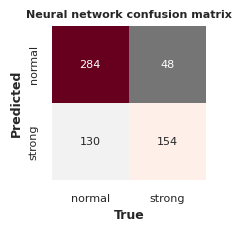

In [41]:
plot_cfm(y_test, y_pred_test, title="Neural network confusion matrix", cmap=CMAP_CFM)

In [42]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                2320      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________


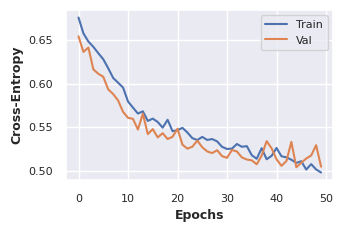

In [43]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

200/200 [==============================] - 0s 2ms/step


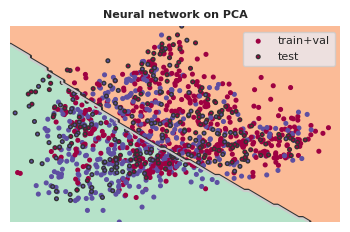

In [44]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=N_PTS,
                       cmap=CMAP,
                       title="Neural network on PCA")

# Ensemble methods

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [46]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 23:53:40,056] A new study created in memory with name: no-name-5b014627-215e-4544-9c0f-b231172acb42
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[W 2023-07-08 23:53:40,081] Trial 3 failed with parameters: {'n_estimators': 1950, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[I 2023-07-08 23:55:41,551] Trial 13 finished with value: 0.7630853994490359 and parameters: {'n_estimators': 320, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7823691460055097.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 23:56:10,178] Trial 10 finished with value: 0.7741046831955923 and parameters: {'n_estimators': 1240, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.7823691460055097.
/home/djanloo/.loc

[W 2023-07-08 23:57:00,070] Trial 22 failed with parameters: {'n_estimators': 1900, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
  

[W 2023-07-08 23:57:00,626] Trial 27 failed with value None.
[W 2023-07-08 23:57:00,777] Trial 28 failed with parameters: {'n_estimators': 1890, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 23:57:01,455] Trial 33 failed with value None.
[W 2023-07-08 23:57:01,560] Trial 34 failed with parameters: {'n_estimators': 1910, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-08 23:57:02,157] Trial 39 failed with value None.
[W 2023-07-08 23:57:02,237] Trial 40 failed with parameters: {'n_estimators': 2000, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 23:57:02,605] Trial 45 failed with value None.
[W 2023-07-08 23:57:02,694] Trial 46 failed with parameters: {'n_estimators': 1960, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

In [47]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 1880, 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       332
           1       0.72      0.70      0.71       284

    accuracy                           0.74       616
   macro avg       0.73      0.73      0.73       616
weighted avg       0.73      0.74      0.74       616

Accuracy 0.7353896103896104
F1-score [0.75780089 0.70840787]


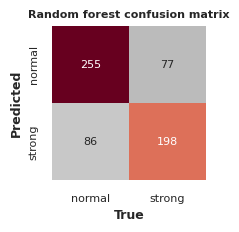

In [48]:
plot_cfm(y_test, y_pred_test, title="Random forest confusion matrix", cmap=CMAP_CFM)

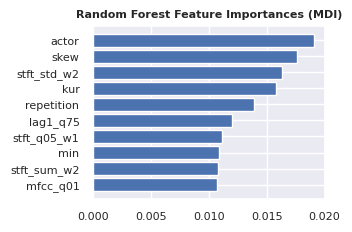

In [49]:
nbr_features = X_train.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

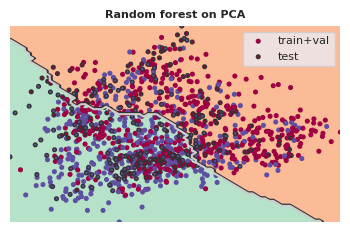

In [50]:
boundaries_on_embedding(reducer, rf, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                        title="Random forest on PCA")

In [51]:
from sklearn.inspection import permutation_importance

In [52]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

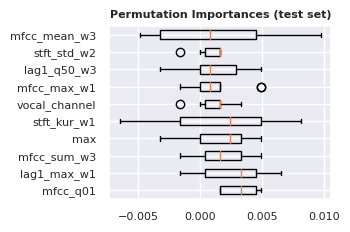

In [53]:
sorted_idx = result.importances_mean.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [54]:
from sklearn.tree import plot_tree

In [55]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_split=3, random_state=1738192604)

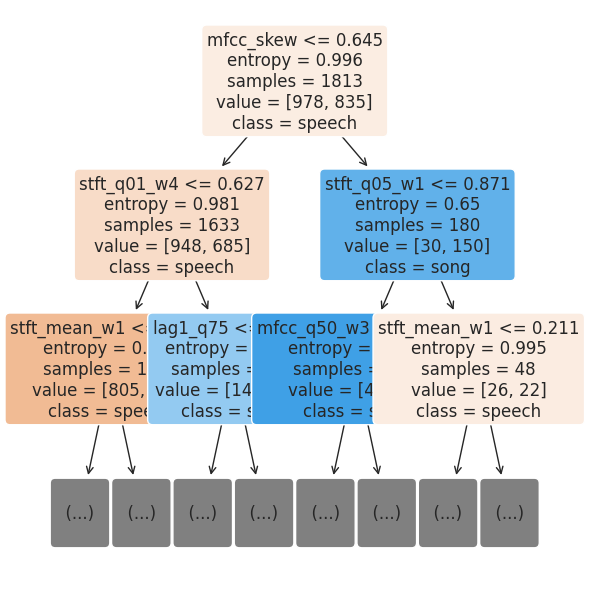

In [56]:
plt.figure(figsize=(6,6))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

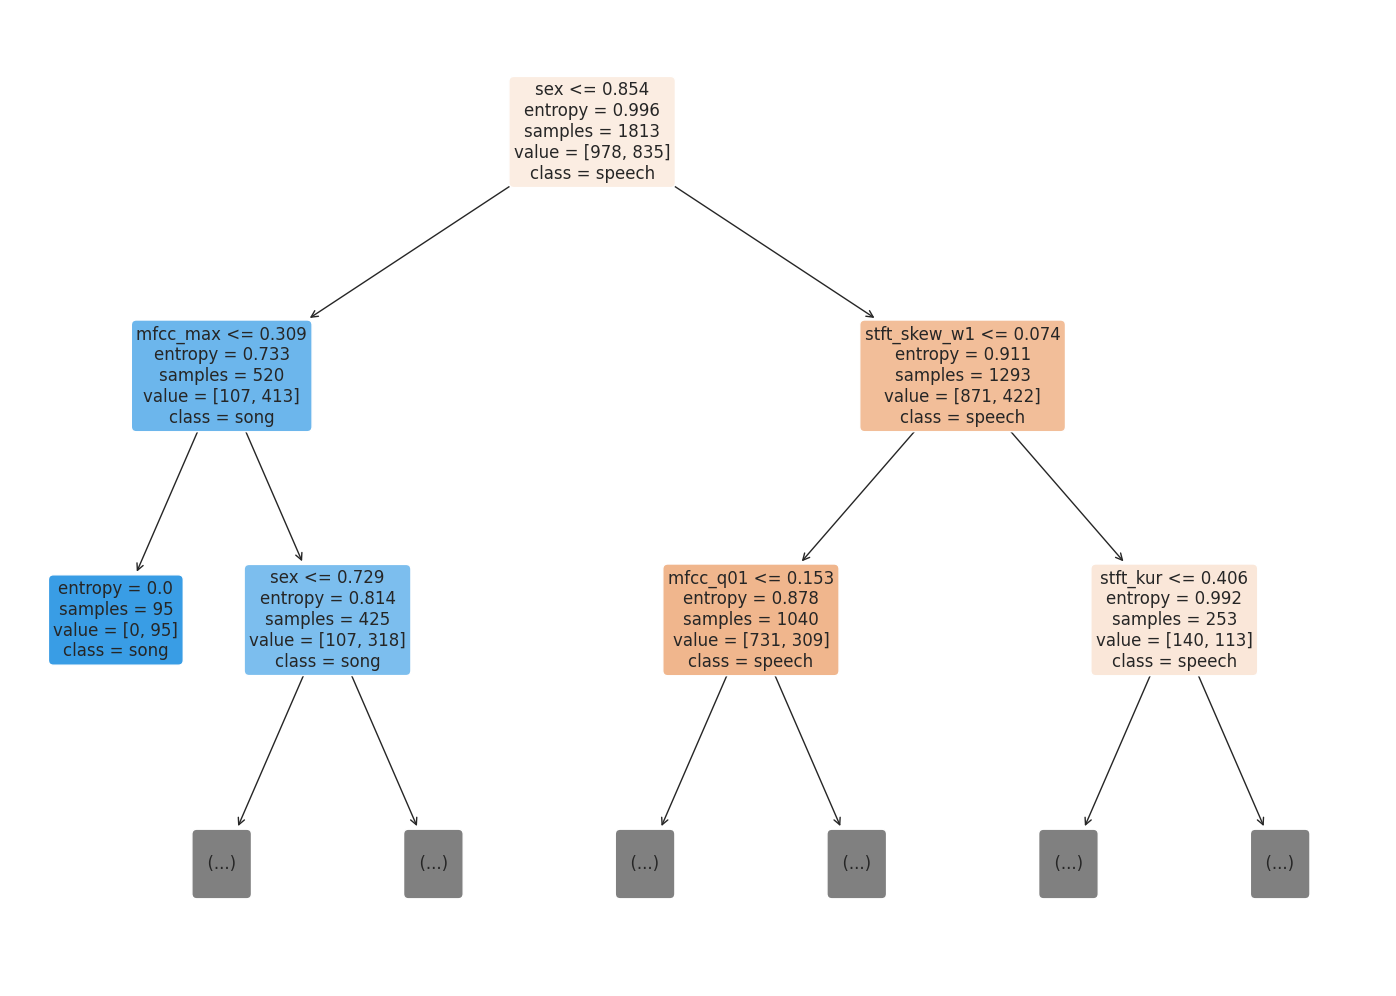

In [57]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [59]:
from sklearn.metrics import class_likelihood_ratios
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    error = accuracy_score(y_val, y_pred)
    L_pos, L_neg = class_likelihood_ratios(y_val, y_pred)

    return L_pos#error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 200, n_jobs = -1, catch=(ValueError,))

[I 2023-07-09 00:14:43,234] A new study created in memory with name: no-name-d1c0d59b-a6a1-4517-8b5a-b92f2b1af8d7
[W 2023-07-09 00:14:43,253] Trial 0 failed with parameters: {'n_estimators': 12, 'max_depth': 90, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 7, 'learning_rate': 0.1639863973911048, 'criterion': 'mae', 'subsample': 0.883671995477562, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_g

[W 2023-07-09 00:14:43,425] Trial 8 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2023-07-09 00:14:43,492] Trial 6 finished with value: 3.913207547169811 and parameters: {'n_estimators': 1, 'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 4, 'learning_rate': 0.06803191844508026, 'criterion': 'friedman_mse', 'subsample': 0.8847739661737968, 'loss': 'deviance'}. Best is trial 6 with value: 3

[I 2023-07-09 00:14:44,288] Trial 9 finished with value: 4.638606676342525 and parameters: {'n_estimators': 14, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 10, 'learning_rate': 0.07644963434701599, 'criterion': 'friedman_mse', 'subsample': 0.5838084560224142, 'loss': 'deviance'}. Best is trial 9 with value: 4.638606676342525.
[W 2023-07-09 00:14:44,297] Trial 18 failed with parameters: {'n_estimators': 1, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 6, 'learning_rate': 0.08493361496283593, 'criterion': 'mae', 'subsample': 0.7779209833952754, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200,

[W 2023-07-09 00:14:45,255] Trial 23 failed with value None.
[W 2023-07-09 00:14:45,266] Trial 24 failed with parameters: {'n_estimators': 1, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 4, 'learning_rate': 0.012981588775178639, 'criterion': 'mae', 'subsample': 0.7359344260839495, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_para

[W 2023-07-09 00:14:46,372] Trial 31 failed with value None.
[W 2023-07-09 00:14:46,444] Trial 32 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.029373107088995258, 'criterion': 'mae', 'subsample': 0.9981556038483458, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 00:14:46,842] Trial 37 failed with value None.
[W 2023-07-09 00:14:46,918] Trial 38 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'learning_rate': 0.025083694903412022, 'criterion': 'mae', 'subsample': 0.9990513698017638, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 00:14:47,297] Trial 43 failed with value None.
[W 2023-07-09 00:14:47,372] Trial 44 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.010115329856130728, 'criterion': 'mae', 'subsample': 0.9640224510293289, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-09 00:14:47,797] Trial 49 failed with value None.
[W 2023-07-09 00:14:47,884] Trial 50 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.03692233995164289, 'criterion': 'mae', 'subsample': 0.9607725888666959, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-09 00:14:48,284] Trial 55 failed with parameters: {'n_estimators': 18, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'learning_rate': 0.03546306907106732, 'criterion': 'mae', 'subsample': 0.9992417458403691, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/

[W 2023-07-09 00:14:48,678] Trial 59 failed with value None.
[I 2023-07-09 00:14:48,682] Trial 29 finished with value: 3.811320754716981 and parameters: {'n_estimators': 10, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 9, 'learning_rate': 0.13664374878065305, 'criterion': 'friedman_mse', 'subsample': 0.6596255261413556, 'loss': 'deviance'}. Best is trial 27 with value: 12.028301886792454.
[W 2023-07-09 00:14:48,683] Trial 60 failed with value None.
[W 2023-07-09 00:14:48,869] Trial 63 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'learning_rate': 0.012314031576238789, 'criterion': 'mae', 'subsample': 0.9771842588688555, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
 

[W 2023-07-09 00:14:49,125] Trial 66 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.024786905017738642, 'criterion': 'mae', 'subsample': 0.9948347274512911, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 00:14:49,610] Trial 72 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.015064937917534795, 'criterion': 'mae', 'subsample': 0.9870256721932354, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 00:14:50,007] Trial 77 failed with value None.
[W 2023-07-09 00:14:50,127] Trial 79 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.0216804433589302, 'criterion': 'mae', 'subsample': 0.9980152553448399, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-09 00:14:50,567] Trial 85 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.0191080602461569, 'criterion': 'mae', 'subsample': 0.988087212252485, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/li

[W 2023-07-09 00:14:50,932] Trial 87 failed with value None.
[W 2023-07-09 00:14:50,963] Trial 88 failed with value None.
[W 2023-07-09 00:14:51,024] Trial 90 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.010759723418817008, 'criterion': 'mae', 'subsample': 0.9933916666326823, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/

[W 2023-07-09 00:14:51,479] Trial 96 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'learning_rate': 0.033535618364407445, 'criterion': 'mae', 'subsample': 0.9972513296229178, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 00:14:51,951] Trial 101 failed with value None.
[W 2023-07-09 00:14:52,013] Trial 102 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.02648361943512024, 'criterion': 'mae', 'subsample': 0.9973294555190942, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 00:14:52,475] Trial 108 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.011731418560887075, 'criterion': 'mae', 'subsample': 0.9687967274963448, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-09 00:14:52,902] Trial 113 failed with value None.
[W 2023-07-09 00:14:52,957] Trial 114 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.01286512670010903, 'criterion': 'mae', 'subsample': 0.9983322014611207, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 00:14:53,259] Trial 119 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.022533941388619624, 'criterion': 'mae', 'subsample': 0.9908958970112225, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-09 00:14:53,715] Trial 124 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.018587016312066613, 'criterion': 'mae', 'subsample': 0.9796151022512238, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-09 00:14:54,110] Trial 128 failed with value None.
[W 2023-07-09 00:14:54,136] Trial 130 failed with value None.
[W 2023-07-09 00:14:54,180] Trial 129 failed with value None.
[W 2023-07-09 00:14:54,182] Trial 131 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 8, 'learning_rate': 0.010701443017227391, 'criterion': 'mae', 'subsample': 0.9794753263757872, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/sha

[W 2023-07-09 00:14:54,626] Trial 135 failed with value None.
[W 2023-07-09 00:14:54,629] Trial 137 failed with parameters: {'n_estimators': 13, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'learning_rate': 0.010038972862981117, 'criterion': 'mae', 'subsample': 0.9943414913044564, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_param

[W 2023-07-09 00:14:55,185] Trial 142 failed with value None.
[W 2023-07-09 00:14:55,206] Trial 144 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 7, 'learning_rate': 0.01313339140450688, 'criterion': 'mae', 'subsample': 0.9875539928469652, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_param

[W 2023-07-09 00:14:55,640] Trial 149 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 7, 'learning_rate': 0.013685078073653656, 'criterion': 'mae', 'subsample': 0.9834288998339213, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRm

[W 2023-07-09 00:14:56,101] Trial 154 failed with value None.
[W 2023-07-09 00:14:56,208] Trial 156 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.03901837430732648, 'criterion': 'mae', 'subsample': 0.9947285698522503, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-09 00:14:56,577] Trial 161 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.010913662145006997, 'criterion': 'mae', 'subsample': 0.999238867468772, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-09 00:14:57,112] Trial 165 failed with value None.
[W 2023-07-09 00:14:57,078] Trial 166 failed with value None.
[W 2023-07-09 00:14:57,059] Trial 167 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 8, 'learning_rate': 0.011110747479598108, 'criterion': 'mae', 'subsample': 0.9939172380341601, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/skle

[W 2023-07-09 00:14:57,438] Trial 170 failed with value None.
[W 2023-07-09 00:14:57,439] Trial 169 failed with value None.
[W 2023-07-09 00:14:57,440] Trial 171 failed with value None.
[W 2023-07-09 00:14:57,442] Trial 172 failed with value None.
[W 2023-07-09 00:14:57,554] Trial 173 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.016379253918572798, 'criterion': 'mae', 'subsample': 0.9856176945645795, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun

[W 2023-07-09 00:14:57,954] Trial 177 failed with value None.
[W 2023-07-09 00:14:58,013] Trial 179 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.015841910385401756, 'criterion': 'mae', 'subsample': 0.9843489456163976, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_param

[W 2023-07-09 00:14:58,419] Trial 182 failed with value None.
[W 2023-07-09 00:14:58,433] Trial 183 failed with value None.
[W 2023-07-09 00:14:58,435] Trial 185 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.01523539378051983, 'criterion': 'mae', 'subsample': 0.9989887023946248, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklear

[W 2023-07-09 00:14:58,813] Trial 188 failed with value None.
[W 2023-07-09 00:14:58,892] Trial 190 failed with value None.
[W 2023-07-09 00:14:58,970] Trial 191 failed with parameters: {'n_estimators': 19, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.016092848650911373, 'criterion': 'mae', 'subsample': 0.9896973288660653, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklea

[W 2023-07-09 00:14:59,391] Trial 196 failed with value None.
[W 2023-07-09 00:14:59,367] Trial 197 failed with parameters: {'n_estimators': 20, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.012525306737723183, 'criterion': 'mae', 'subsample': 0.9849147475580331, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_140956/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_param

In [60]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 13, 'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 4, 'learning_rate': 0.018316262557346717, 'criterion': 'friedman_mse', 'subsample': 0.9720561745072356, 'loss': 'exponential'}
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       332
           1       0.78      0.46      0.58       284

    accuracy                           0.69       616
   macro avg       0.72      0.67      0.67       616
weighted avg       0.71      0.69      0.67       616

Accuracy 0.6915584415584416
F1-score [0.75641026 0.57964602]


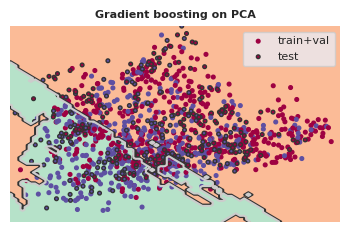

In [61]:
boundaries_on_embedding(reducer, gb, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                       title="Gradient boosting on PCA")

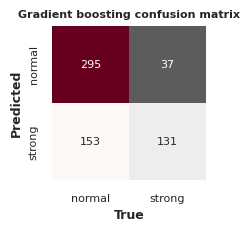

In [62]:
plot_cfm(y_test, y_pred_test, title="Gradient boosting confusion matrix", cmap=CMAP_CFM)